In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
import pickle


In [14]:
# ===================== function ===========================================
# Plot the training and validation accuracy and loss
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    #plt.legend()
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
def saveScaller(scaler):
    with open('scaller.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    

In [22]:
df = pd.read_csv('data/cleaned_remaining_na_-1.csv')

X = df.drop(columns=['id', 'churn',"service_failure_count"])
print(df["churn"].value_counts())
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 1: Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


churn
1    40050
0    31843
Name: count, dtype: int64


In [23]:
# ==== Save Scaller ===
saveScaller(scaler)

In [19]:
print(X.isnull().sum(), y_train.isnull().sum())  # For pandas DataFrame

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
remaining_contract             0
download_avg                   0
upload_avg                     0
download_over_limit            0
dtype: int64 0


In [24]:
# Step 2: Build the neural network model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),  # Input layer and first hidden layer
    Dropout(0.25),
    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.25),
    Dense(32, activation='relu'),  # Second hidden layer
    Dropout(0.25),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 3: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], )

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

# Step 5: Evaluate the model
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")  # Convert probabilities to binary predictions




Epoch 1/100


/home/lago/.local/share/virtualenvs/project1_group2-GxMnXhxh/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8698 - loss: 0.3533 - val_accuracy: 0.9117 - val_loss: 0.2611
Epoch 2/100
1551/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9114 - loss: 0.2691

KeyboardInterrupt: 

In [ ]:
model.save('nn.h5')

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))


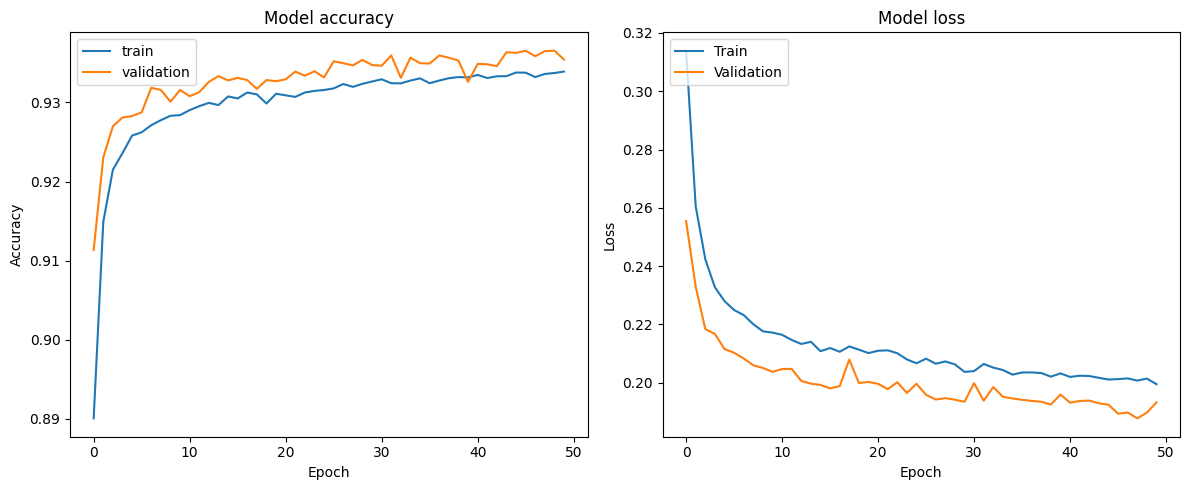

In [51]:
plot_training_history(history)

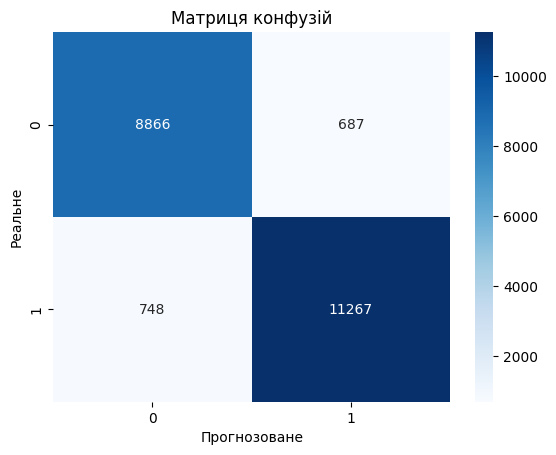

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця конфузій')
plt.xlabel('Прогнозоване')
plt.ylabel('Реальне')
plt.show()

In [12]:
filtered_df = df[df['remaining_contract'] < 0.01] #only people whose contract is over or nan
X2 = filtered_df.drop(columns=['id', 'churn',"service_failure_count", "remaining_contract"])
print(X2.shape)
y2 = filtered_df['churn']
print(y2.shape)


(37881, 7)
(37881,)


In [13]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)

# Step 1: Preprocess the data
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)
#plt.hist(df["remaining_contract"])

In [14]:
print(X2.isnull().sum())  # For pandas DataFrame
print(y2_train.isnull().sum())
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y2_train), y=y2_train)
class_weights = dict(enumerate(weights))
class_weights

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
download_avg                   0
upload_avg                     0
download_over_limit            0
dtype: int64
0


{0: 10.1206106870229, 1: 0.52598587637864}

In [15]:
# Step 2: Build the neural network model
model = Sequential([
    Dense(128, input_shape=(X2_train.shape[1],), activation='relu'),  # Input layer and first hidden layer
    Dropout(0.25),
    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.25),
    Dense(32, activation='relu'),  # Second hidden layer
    Dropout(0.25),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 3: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history2 = model.fit(X2_train_scaled, y2_train, epochs=100, batch_size=32, class_weight=class_weights, validation_data=(X2_test_scaled, y2_test))

# Step 5: Evaluate the model
y2_pred = (model.predict(X2_test_scaled) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print the classification report
print(classification_report(y2_test, y2_pred))
plot_training_history(history2)

/home/lago/.local/share/virtualenvs/project1_group2-GxMnXhxh/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyError: 0

In [ ]:
#conf_matrix = confusion_matrix(y_test, y_pred)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('Матриця конфузій')
#plt.xlabel('Прогнозоване')
#plt.ylabel('Реальне')
#plt.show()